# ResNet

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Plain Networks

In [2]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

In [22]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*2, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*2, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

In [23]:
 def build_plain(num_cnn_list,
                 channel_list,
                 is_50=True,
                 input_shape=(32,32,3),
                 num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (3,3), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    output = keras.layers.Dense(num_classes, activation='softmax', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name='Plain_34')
    
    return model


### Plain-34

In [24]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_first (Conv2D)          (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_first (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
act_first (Activation)       (None, 16, 16, 64)        0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 8, 8, 64)          256

### Plain-50

In [26]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True)
plain_50.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_first (Conv2D)          (None, 16, 16, 64)        1792      
_________________________________________________________________
batch_first (BatchNormalizat (None, 16, 16, 64)        256       
_________________________________________________________________
act_first (Activation)       (None, 16, 16, 64)        0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 8, 8, 64)          256

## ResNet

### Residual block

#### ResNet-34

In [45]:
def build_resnet_34_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    x = input_layer
    
    if block_num > 0:
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                strides=2,
                                name=f'block{block_num}_conv_half')(x)

    for cnn_num in range(num_cnn):
        identity = x
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}_0')(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_batchnorm{cnn_num}_0')(x)
        x = keras.layers.Activation('relu',
                                   name=f'block{block_num}_activation{cnn_num}_0')(x)
        
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}_1')(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_batchnorm{cnn_num}_1')(x)
        
        x = keras.layers.Add(name=f'block{block_num}_add{cnn_num}')([x, identity])
        x = keras.layers.Activation('relu',
                                   name=f'block{block_num}_activation{cnn_num}_1')(x)

    return x

#### ResNet-50

In [ ]:
def build_resnet_50_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    x = input_layer
    
    if block_num > 0:
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                strides=2,
                                name=f'block{block_num}_conv_half')(x)

    for cnn_num in range(num_cnn):
        identity = x
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}_0')(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_batchnorm{cnn_num}_0')(x)
        x = keras.layers.Activation('relu',
                                   name=f'block{block_num}_activation{cnn_num}_0')(x)
        
        x = keras.layers.Conv2D(filters=channel,
                                kernel_size=(3,3),
                                kernel_initializer='he_normal',
                                padding='same',
                                name=f'block{block_num}_conv{cnn_num}_1')(x)
        x = keras.layers.BatchNormalization(name=f'block{block_num}_batchnorm{cnn_num}_1')(x)
        
        x = keras.layers.Add(name=f'block{block_num}_add{cnn_num}')([x, identity])
        x = keras.layers.Activation('relu',
                                   name=f'block{block_num}_activation{cnn_num}_1')(x)

    return x

### Build ResNet

In [46]:
def build_resnet(num_cnn_list,
                 channel_list,
                 is_50=True,
                 input_shape=(32,32,3),
                 num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    output = keras.layers.Conv2D(filters=64,
                                 kernel_size=(3,3),
                                 kernel_initializer='he_normal',
                                 padding='same',
                                 strides=2,
                                 name='conv_0')(input_layer)
    output = keras.layers.BatchNormalization(name='batchnorm_0')(output)
    output = keras.layers.Activation('relu', name='activation_0')(output)
    output = keras.layers.MaxPool2D(pool_size=(2,2),
                                   strides=2,
                                   name='maxpool_0')(output)
    
    # Residual block
    # ResNet 50
    if is_50:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_resnet_50_block(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                block_num=i
            )
    # ResNet 34
    else:
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            output = build_resnet_34_block(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                block_num=i
            )
        
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### ResNet-34

In [47]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                        is_50=False)
resnet_34.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 16, 16, 64)   1792        input_17[0][0]                   
__________________________________________________________________________________________________
batchnorm_0 (BatchNormalization (None, 16, 16, 64)   256         conv_0[0][0]                     
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 16, 16, 64)   0           batchnorm_0[0][0]                
______________________________________________________________________________________

### ResNet-50

In [5]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                        is_50=True)
resnet_50.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

## ResNet-34 vs ResNet-50 vs Plain-34 vs Plain-50

### Dataset (CIFAR-10)

In [31]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [32]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [33]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [35]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [36]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

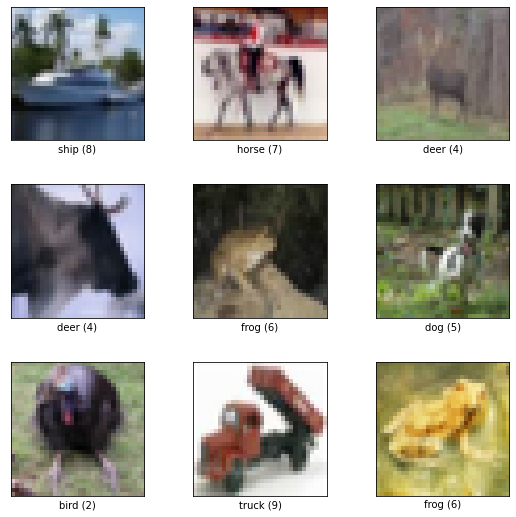

In [37]:
fig = tfds.show_examples(ds_train, ds_info)

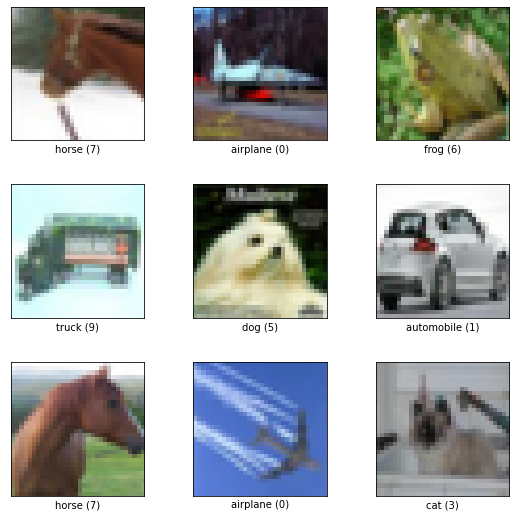

In [38]:
fig = tfds.show_examples(ds_test, ds_info)

### Train

In [39]:
BATCH_SIZE = 256
EPOCH = 40

In [40]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [17]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
  2/195 [..............................] - ETA: 7s - loss: 2.3117 - accuracy: 0.0859WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0229s vs `on_train_batch_end` time: 0.0516s). Check your callbacks.


195/195 [==============================] - 25s 129ms/step - loss: 1.9141 - accuracy: 0.2888 - val_loss: 1.6883 - val_accuracy: 0.3682
Epoch 2/40
195/195 [==============================] - 31s 160ms/step - loss: 1.4868 - accuracy: 0.4586 - val_loss: 1.3827 - val_accuracy: 0.5053
Epoch 3/40
195/195 [==============================] - 16s 83ms/step - loss: 1.2439 - accuracy: 0.5502 - val_loss: 1.1579 - val_accuracy: 0.5777
Epoch 4/40
195/195 [==============================] - 16s 82ms/step - loss: 1.0525 - accuracy: 0.6241 - val_loss: 1.0040 - val_accuracy: 0.6441
Epoch 5/40
195/195 [==============================] - 16s 82ms/step - loss: 0.9181 - accuracy: 0.6746 - val_loss: 0.9171 - val_accuracy: 0.6730
Epoch 6/40
195/195 [==============================] - 16s 82ms/step - loss: 0.7911 - accuracy: 0.7220 - val_loss: 0.9161 - val_accuracy: 0.6838
Epoch 7/40
195/195 [==============================] - 16s 82ms/step - loss: 0.6904 - accuracy: 0.7576 - val_loss: 0.9093 - val_accuracy: 0.6974
E

In [19]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = vgg_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
  2/195 [..............................] - ETA: 21s - loss: 2.3029 - accuracy: 0.0957WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0393s vs `on_train_batch_end` time: 0.0795s). Check your callbacks.


195/195 [==============================] - 21s 105ms/step - loss: 2.0146 - accuracy: 0.2471 - val_loss: 1.6605 - val_accuracy: 0.3951
Epoch 2/40
195/195 [==============================] - 19s 97ms/step - loss: 1.5931 - accuracy: 0.4127 - val_loss: 1.4075 - val_accuracy: 0.4857
Epoch 3/40
195/195 [==============================] - 19s 98ms/step - loss: 1.3394 - accuracy: 0.5148 - val_loss: 1.2321 - val_accuracy: 0.5529
Epoch 4/40
195/195 [==============================] - 19s 98ms/step - loss: 1.1475 - accuracy: 0.5879 - val_loss: 1.2140 - val_accuracy: 0.5650
Epoch 5/40
195/195 [==============================] - 19s 98ms/step - loss: 1.0215 - accuracy: 0.6383 - val_loss: 1.0271 - val_accuracy: 0.6433
Epoch 6/40
195/195 [==============================] - 19s 99ms/step - loss: 0.8967 - accuracy: 0.6847 - val_loss: 1.0011 - val_accuracy: 0.6627
Epoch 7/40
195/195 [==============================] - 19s 98ms/step - loss: 0.7791 - accuracy: 0.7237 - val_loss: 0.8417 - val_accuracy: 0.7076
Ep

### Comparison

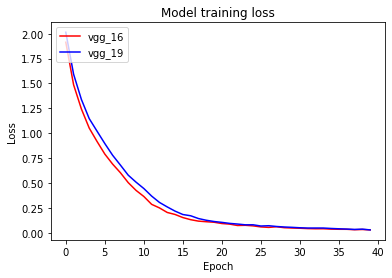

In [20]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

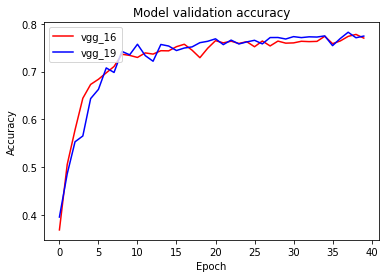

In [21]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()